Imports


In [9]:
import matplotlib.pyplot as plt
import sklearn.datasets as datasets
import numpy as np

import random
from datetime import date

import torch
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader

! pip install nflows
from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal, ConditionalDiagonalNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation

# MNIST

In [10]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  torch.cuda.set_device(device)

In [11]:
import gzip
import pickle

def load_data():
  f = gzip.open('mnist.pkl.gz', 'rb')

  # fix for encoding of pickle
  u = pickle._Unpickler(f)
  u.encoding = 'latin1'

  train_data, validation_data, test_data = u.load()
  f.close()

  return (train_data, validation_data, test_data)

In [12]:
def preprocess_data(data, rng, alpha=1.0e-6, logit=False, should_dequantize=True):
  """
  Processes the dataset
  """
  x = dequantize(data[0], rng) if should_dequantize else data[0]  # dequantize pixels
  x = logit_transform(x, alpha) if logit else x                   # logit
  labels = data[1]                                                # numeric labels
  encoded_labels = one_hot_encode(labels, 10)                     # 1-hot encoded labels
  return (x, labels, encoded_labels)

def dequantize(x, rng):
  """
  Adds noise to pixels to dequantize them
  """
  return x + rng.rand(*x.shape) / 256.0

def logit_transform(x, alpha=1.0e-6):
  """
  Transforms pixel values with logit to reduce the impact of boundary effects
  """
  a = alpha + (1 - 2*alpha) * x
  return np.log(a / (1.0 - a))

def one_hot_encode(labels, nr_labels):
  """
  Transforms numeric labels to 1-hot encoded labels
  """
  y = np.zeros([labels.size, nr_labels])
  y[range(labels.size), labels] = 1
  return y

In [13]:
def load_vectorized_data():
  train_data, validation_data, test_data = load_data()
  rng = np.random.RandomState(42)

  processed_train_data = preprocess_data(train_data, rng, logit=True)
  processed_validation_data = preprocess_data(validation_data, rng, logit=True)
  processed_test_data = preprocess_data(test_data, rng, logit=True)
  
  return (processed_train_data, processed_validation_data, processed_test_data)

In [68]:
train_data, validation_data, test_data = load_vectorized_data()

train_x = train_data[0]
train_labels = train_data[1]
train_y = train_data[2]

val_x = validation_data[0]
val_labels = validation_data[1]
val_y = validation_data[2]

test_x = test_data[0]
test_labels = test_data[1]
test_y = test_data[2]

In [15]:
def build_flow(num_dim, hidden_features=1024, layers=5, batch_norm=False):
  base_dist = StandardNormal(shape=[num_dim])
  transforms = []
  
  for _ in range(layers):
    transforms.append(ReversePermutation(features=num_dim))
    transforms.append(MaskedAffineAutoregressiveTransform(features=num_dim,
                                                          hidden_features=hidden_features,
                                                          use_batch_norm=batch_norm))
  transform = CompositeTransform(transforms)
  return Flow(transform, base_dist)

In [16]:
def build_cond_flow(num_dim, condition='digit', hidden_features=1024, layers=5, batch_norm=False):
  posible_conditioning = { 'digit': 10, 'color': 3 }
  context_features = posible_conditioning.get(condition, 1)
  base_dist = ConditionalDiagonalNormal(shape=[num_dim],
                                        context_encoder=nn.Linear(context_features, 2 * num_dim))
  transforms = []
  
  for _ in range(layers):
    transforms.append(ReversePermutation(features=num_dim))
    transforms.append(MaskedAffineAutoregressiveTransform(features=num_dim,
                                                          hidden_features=hidden_features,
                                                          use_batch_norm=batch_norm,
                                                          context_features=context_features))
  
  transform = CompositeTransform(transforms)
  return Flow(transform, base_dist)

In [17]:
def plot_loss_progress(progress_trn_loss, progress_val_loss, progress_epoch, best_epoch):
  fig, ax = plt.subplots(1, 1)
  ax.semilogx(progress_epoch, progress_trn_loss, 'b', label='training')
  ax.semilogx(progress_epoch, progress_val_loss, 'r', label='validation')
  ax.vlines(best_epoch, ax.get_ylim()[0], ax.get_ylim()[1], color='g', linestyles='dashed', label='best')
  ax.set_xlabel('epochs')
  ax.set_ylabel('loss')
  ax.legend()
  plt.show(block=False)

In [64]:
def train(train_x, train_labels, train_loader, val_loader, maxepochs=1, monitor_every_batch=False, show_epoch_loss_progress=False, show_flow=False, weight_decay=None, conditional=False, conditioning_criteria='digit'):
  num_dim = train_x.shape[1]
  lr = 1.0e-4
  best_val_loss = float('inf')
  best_epoch = None
  progress_epoch = []
  progress_trn_loss = []
  progress_val_loss = []
  flow = build_cond_flow(num_dim, condition=conditioning_criteria) if conditional else build_flow(num_dim)

  if torch.cuda.is_available():
    flow = flow.to(device)
  
  optimizer = optim.Adam(flow.parameters(),
                         lr=lr,
                         weight_decay=0 if weight_decay is None else weight_decay)

  # scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: min(1., epoch / 10))

  for epoch in range(1, maxepochs + 1):
    iter = 1

    t_loss = 0.0
    for x, y, l in train_loader:
      # print(y[0])
      optimizer.zero_grad()
      train_loss = -flow.log_prob(inputs=x, context=y).mean() if conditional else -flow.log_prob(inputs=x).mean()
      train_loss.backward()
      optimizer.step()

      t_loss = train_loss.cpu().detach().numpy() if torch.cuda.is_available() else train_loss.detach().numpy()
      
      if monitor_every_batch:
        print('Epoch {}, Iteration {}, Train loss {:.5f}'.format(epoch, iter, t_loss))

      iter += 1

    v_loss = 0.0
    with torch.no_grad():
      for x, y, l in val_loader:
        val_loss = -flow.log_prob(inputs=x, context=y).mean() if conditional else -flow.log_prob(inputs=x).mean()
        v_loss = val_loss.cpu().detach().numpy() if torch.cuda.is_available() else val_loss.detach().numpy()
      
    progress_trn_loss.append(t_loss)
    progress_val_loss.append(v_loss)
    progress_epoch.append(epoch)

    print('Epoch: {}, Train loss: {:.5f}, Validation loss: {:.5f}'.format(epoch, t_loss, v_loss))

    if best_val_loss > v_loss:
      best_val_loss = v_loss
      today = date.today().strftime("%d-%m-%Y")
      filename = "MAF-MNIST-{}-{}-best.pth".format(conditioning_criteria if conditional else '', today)
      torch.save(flow, "/content/drive/MyDrive/Colab Notebooks/{}".format(filename))
      best_epoch = epoch
    
  if show_epoch_loss_progress:
    plot_loss_progress(progress_trn_loss, progress_val_loss, progress_epoch, best_epoch)

  return flow

In [69]:
conditioning_criteria = 'color'

if conditioning_criteria == 'color':
  (train_x, train_y) = color_features(train_x, randomize=True)
  (val_x, val_y) = color_features(val_x, randomize=True)

tt_train_x = torch.tensor(train_x, dtype=torch.float32)
tt_train_y = torch.tensor(train_y, dtype=torch.float32)
tt_train_labels = torch.tensor(train_labels, dtype=torch.float32)

tt_val_x = torch.tensor(val_x, dtype=torch.float32)
tt_val_y = torch.tensor(val_y, dtype=torch.float32)
tt_val_labels = torch.tensor(val_labels, dtype=torch.float32)

if torch.cuda.is_available():
  tt_train_x = tt_train_x.to(device)
  tt_train_y = tt_train_y.to(device)
  tt_train_labels = tt_train_labels.to(device)

  tt_val_x = tt_val_x.to(device)
  tt_val_y = tt_val_y.to(device)
  tt_val_labels = tt_val_labels.to(device)

train_set = TensorDataset(tt_train_x, tt_train_y, tt_train_labels)
val_set = TensorDataset(tt_val_x, tt_val_y, tt_val_labels)

batch_size = 100
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)

In [70]:
def color_features(input, randomize=False):
  np.random.seed(42)
  colors = []
  colored_input = np.zeros((input.shape[0], 3, input.shape[1]))

  if randomize:
    rng = np.random.RandomState(42)
    colored_input = dequantize(colored_input, rng)

  for i in range(len(input))[:]:
    r = np.random.permutation([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    # print(r[0])
    colors.append(r[0])
    # print(np.argmax(r[0]))
    colored_input[i][np.argmax(r[0])][:] = input[i]
  
  colored_input = colored_input.reshape(colored_input.shape[0], 3*28*28)

  return (colored_input, np.array(colors))

Epoch: 1, Train loss: -5933.34619, Validation loss: -5987.27686
Epoch: 2, Train loss: -4539.14404, Validation loss: -4643.97656
Epoch: 3, Train loss: -5930.62793, Validation loss: -5997.41846
Epoch: 4, Train loss: -6318.31348, Validation loss: -6335.98096
Epoch: 5, Train loss: -6468.08350, Validation loss: -6457.81738
Epoch: 6, Train loss: -6523.33008, Validation loss: -6529.95361
Epoch: 7, Train loss: -6541.13867, Validation loss: -6566.61475
Epoch: 8, Train loss: -6595.43115, Validation loss: -6610.06006
Epoch: 9, Train loss: -6653.19873, Validation loss: -6635.95801
Epoch: 10, Train loss: -6679.05615, Validation loss: -6684.85156
Epoch: 11, Train loss: -6692.60059, Validation loss: -6694.79492
Epoch: 12, Train loss: -6698.91406, Validation loss: -6705.97363
Epoch: 13, Train loss: -6754.43506, Validation loss: -6721.69092
Epoch: 14, Train loss: -6751.47217, Validation loss: -6750.50781
Epoch: 15, Train loss: -6773.44971, Validation loss: -6786.34912
Epoch: 16, Train loss: -6811.74609

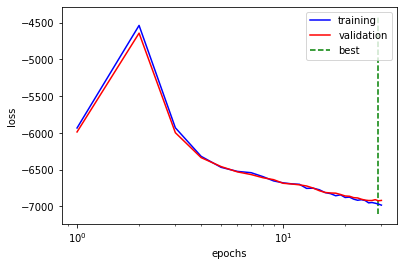

In [71]:
epochs = 30
wd_rate = 1.0e-6
conditioning_criteria = 'color'
model = train(tt_train_x, 
              train_labels, 
              train_loader, 
              val_loader, 
              maxepochs=epochs, 
              weight_decay=wd_rate,
              show_epoch_loss_progress=True,
              conditional=True,
              conditioning_criteria=conditioning_criteria)

In [ ]:
tt_train_labels.reshape(-1, 1).shape

torch.Size([50000, 1])

In [ ]:
train_y.shape

(50000, 10)

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
torch.save(model, "/content/drive/MyDrive/Colab Notebooks/MAF-MNIST-2-11-2021-best.pth")

In [ ]:
model = torch.load('/content/drive/MyDrive/Colab Notebooks/MAF-MNIST-digit-cond-16-11-2021-best.pth', map_location=torch.device('cpu'))

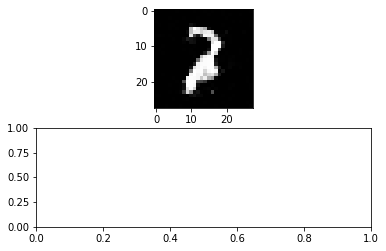

In [ ]:
with torch.no_grad():
  z = model.sample(2)

fig, axs = plt.subplots(2)
z_cpu = z[0].cpu()

axs[0].imshow(inv_logit(z_cpu).detach().numpy().reshape(28,28), cmap='gray')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


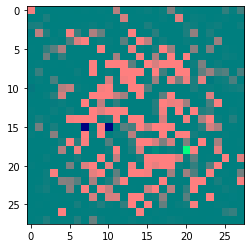

In [38]:
with torch.no_grad():
  z = model.sample(1, context=tt_train_y[0].reshape(-1, 3))
  z_cpu = z[0].cpu()
  plt.imshow(np.transpose(inv_logit(z_cpu).detach().numpy().reshape(3,28,28), (1,2,0)))
  plt.show()

In [42]:
tt_train_y[0].shape

torch.Size([3])

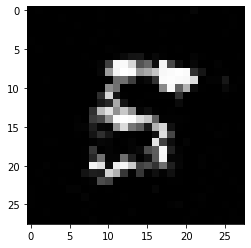

In [ ]:
plt.imshow(inv_logit(z_cpu).detach().numpy().reshape(28,28), cmap='gray')
plt.show()

In [ ]:
print(np.argmax(tt_train_y[0]))

tensor(5)


In [30]:
def inv_logit(x):
  alpha = 1.0e-6
  return (1.0 / (1.0 + np.exp(-x)) - alpha) / (1 - 2*alpha) 

Test data

In [ ]:
tt_test_x = torch.tensor(test_x, dtype=torch.float32)
tt_test_y = torch.tensor(test_y, dtype=torch.float32)
tt_test_labels = torch.tensor(test_labels, dtype=torch.float32)

if torch.cuda.is_available():
  tt_test_x = tt_test_x.to(device)
  tt_test_y = tt_test_y.to(device)
  tt_test_labels = tt_test_labels.to(device)



# Conditioned Moons


In [ ]:
import sklearn.datasets as datasets

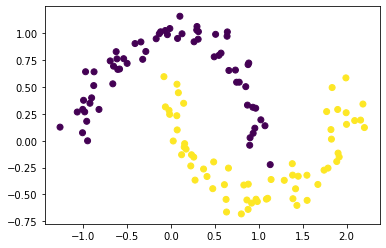

In [ ]:
x, y = datasets.make_moons(128, noise=.1)
plt.scatter(x[:, 0], x[:, 1], c=y);

In [ ]:
num_layers = 5
base_dist = ConditionalDiagonalNormal(shape=[2], 
                                      context_encoder=nn.Linear(1, 4))

transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=2))
    transforms.append(MaskedAffineAutoregressiveTransform(features=2, 
                                                          hidden_features=4, 
                                                          context_features=1))
transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)
optimizer = optim.Adam(flow.parameters())

In [ ]:
num_iter = 5000
for i in range(num_iter):
    x, y = datasets.make_moons(128, noise=.1)
    x = torch.tensor(x, dtype=torch.float32)
    print("x:{}".format(x.shape))
    y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)
    print("y:{}".format(y.shape))
    optimizer.zero_grad()
    loss = -flow.log_prob(inputs=x, context=y).mean()
    loss.backward()
    optimizer.step()
    
    if (i + 1) % 500 == 0:
        fig, ax = plt.subplots(1, 2)
        xline = torch.linspace(-1.5, 2.5)
        yline = torch.linspace(-.75, 1.25)
        xgrid, ygrid = torch.meshgrid(xline, yline)
        xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

        with torch.no_grad():
            zgrid0 = flow.log_prob(xyinput, torch.zeros(10000, 1)).exp().reshape(100, 100)
            zgrid1 = flow.log_prob(xyinput, torch.ones(10000, 1)).exp().reshape(100, 100)

        ax[0].contourf(xgrid.numpy(), ygrid.numpy(), zgrid0.numpy())
        ax[1].contourf(xgrid.numpy(), ygrid.numpy(), zgrid1.numpy())
        plt.title('iteration {}'.format(i + 1))
        plt.show()

In [ ]:
x, y = datasets.make_moons(128, noise=.1)
train_y[0].reshape(-1, 1).shape
print(train_x.shape)
print(train_y.shape)

(50000, 784)
(50000, 10)
